## Model Inspection

#### Imports

In [1]:
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.keras.api import keras

from hpcscripts.sharedutils.nomalization import *
from hpcscripts.trainers.windowmanager import WindowGenerator
from hpcscripts.sharedutils.trainingutils import LoadModel, SetLowTFVerbose, MakeSinglePrediction, CreateWindowGenerator, ImportCombinedTrainingData, GetFileList
from hpcscripts.sharedutils.nomalization import DF_Nomalize, denorm
from hpcscripts.sharedutils.modelutils import SelectModelPrompt
from hpcscripts.option import pathhandler as ph
from hpcscripts.option import globalparams as G_PARAMS

2022-09-09 01:02:34.997098: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-09 01:02:35.006104: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


### Function Definitions

In [2]:
# Get Training Data to calculate norm param
train_file = os.path.join(ph.GetProcessedPath("Combined"), "Train_set.csv")
train_data, NORM_PARAM = DF_Nomalize(pd.read_csv(train_file))

# Make TensorFlow Quiet
SetLowTFVerbose()

# rad2deg
rad2deg = 180 / math.pi

labels = G_PARAMS.SEQUENTIAL_LABELS

In [3]:
def get_file_list():
    train_dir = ph.GetProcessedPath("Selected")
    test_dir  = ph.GetProcessedPath("Test")

    train_list = os.listdir(train_dir)
    test_list  = os.listdir(test_dir)

    for i, test_file in enumerate (test_list):
        train_list.remove(test_file)
        test_list[i] = os.path.join(test_dir, test_file)

    for i, train_file in enumerate (train_list):
        train_list[i] = os.path.join(train_dir, train_file)

    print ("Files found: ")
    print ("\tTrain count: {}".format(len(train_list)))
    print ("\tTest count : {}".format(len(test_list)))

    # Slicing
    print ("\nAfter Slicing: ")
    # train_list = train_list[:3]
    # test_list  = test_list[:3]

    print ("\tTrain count: {}".format(len(train_list)))
    print ("\tTest count : {}".format(len(test_list)))

    return train_list, test_list

In [4]:
def Predict(filename: str, model, window, NORM_PARAM=NORM_PARAM):
    prediction_dict = {}
    file_path = os.path.join (ph.GetProcessedPath("Test"), filename)

    test_df, predictions = MakeSinglePrediction(file_path, model, window)

    for i, label in enumerate(labels):
        z, s = NORM_PARAM[label]
        zt,st= NORM_PARAM["time_s"]

        denormed_time  = denorm(test_df["time_s"].to_numpy(), zt, st)
        denormed_label = denorm(test_df[label], z, s)
        denormed_pred  = denorm(predictions[:, i], z, s)

        if (label.endswith("rad")):
            denormed_pred = denormed_pred * rad2deg
            denormed_label= denormed_label* rad2deg

        prediction_dict[label] = (denormed_label, denormed_pred)
    
    return denormed_time, prediction_dict

def ShowPrediction(filename: str, model, window, NORM_PARAM=NORM_PARAM,
                win_start: int=0, win_end: int=-1
):
    denormed_time, prediction_dict = Predict(filename, model, window, NORM_PARAM)

    for i, label in enumerate(labels):
        denormed_label, denormed_pred = prediction_dict[label]

        # plt.plot(denormed_time[win_start:win_end], denormed_label[win_start:win_end])
        plt.scatter(denormed_time[win_start:win_end], denormed_label[win_start:win_end], c='r', marker='X')
        plt.scatter(denormed_time[win_start:win_end], denormed_pred[win_start:win_end], c='b', marker='*')

        print ("timespan: {}".format(denormed_time[-1] - denormed_time[0]))
        print ("mae: {}".format(keras.metrics.mean_absolute_error(denormed_label, denormed_pred)))

        plt.legend(["real", "prediction"])
        plt.xlabel(label.removesuffix("rad")+"deg" if label.endswith("rad") else label)
        plt.show()

def ShowComparison(filename: str, model, window, NORM_PARAM=NORM_PARAM,
                win_start: int=0, win_end: int=-1
):
    denormed_time, prediction_dict = Predict(filename, model, window, NORM_PARAM)

    for i, label in enumerate(labels):
        denormed_label, denormed_pred = prediction_dict[label]

        label_min = float (denormed_label[win_start:win_end].min())
        label_max = float (denormed_label[win_start:win_end].max())
        eq_line = np.linspace(label_min, label_max, denormed_label[win_start:win_end].shape[0])

        # plt.plot(denormed_time[win_start:win_end], denormed_label[win_start:win_end])
        plt.scatter(denormed_label[win_start:win_end], denormed_pred[win_start:win_end], c='r', marker='X')
        plt.plot(eq_line, eq_line)

        print ("timespan: {}".format(denormed_time[-1] - denormed_time[0]))
        print ("mae: {}".format(keras.metrics.mean_absolute_error(denormed_label, denormed_pred)))

        plt.legend(["real", "prediction"])
        plt.xlabel(label.removesuffix("rad")+"deg" if label.endswith("rad") else label)
        plt.show()

In [5]:
def PredictFore():
    pass

## Importing Model

In [6]:
model_dir = ph.GetModelsPath()
model_dir = SelectModelPrompt(model_dir)

print ()
model, model_history, modelsmeta = LoadModel(model_dir)

G_PARAMS.SetParams(modelsmeta['param'])

epochs = [a+1 for a in range(len(model_history['loss']))]
print ("\nmodel_id: {}".format(modelsmeta['model_id']))
print ("model_history keys: {}".format(model_history.keys()))
print ("modelsmeta: {}".format(modelsmeta))

Found 5 models inside /home/ikhwansh/Datas/Cool Yeah/TeA/HPC_Scripts/Data/Models:
index    Model-name
  [0].   Baseline
  [1].   Conv
  [2].   Dense
  [3].   GRU
  [4].   LSTM
You selected model Conv


model loaded
model history loaded
model metadata loaded

model_id: tune_conv_0
model_history keys: dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])
modelsmeta: {'model_id': 'tune_conv_0', 'param': (20, 1, 1, None, ['hralt_m', 'hdot_1_mps', 'theta_rad', 'cas_mps', 'gamma_error_rad', 'tailwind_mps', 'g_err_d_rad'], ['elv_l_rad', 'N1s_rpm'], False)}


In [7]:
model_history['val_mean_absolute_error']

[0.45615851879119873,
 0.4428342580795288,
 0.43786993622779846,
 0.42895326018333435,
 0.4294276535511017]

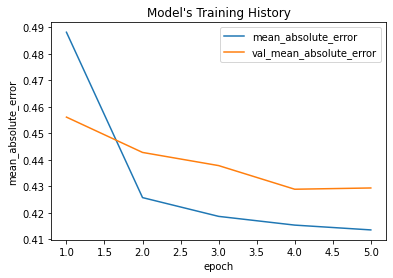

In [8]:
metric = 'mean_absolute_error'
plt.plot(epochs, model_history[metric])
plt.plot(epochs, model_history['val_{}'.format(metric)])

plt.xlabel("epoch")
plt.ylabel(metric)
plt.title("Model's Training History")
plt.legend([metric, 'val_{}'.format(metric)])
plt.show()

In [9]:
_z, _s = NORM_PARAM['elv_l_rad']
last_val_MAE = model_history['val_mean_absolute_error'][-1]

print ("denormed MAE: {}".format(denorm(last_val_MAE, _z, _s)))
print ("denormed MAE: {}".format(denorm(0.0000, _z, _s)))

elv_MAE = denorm(last_val_MAE, _z, _s)-denorm(0.0000, _z, _s)
elv_MAE = elv_MAE*180/math.pi 
print ("MAE: {} deg".format(elv_MAE))


denormed MAE: -0.06383421626475702
denormed MAE: -0.08195467013597951
MAE: 1.038225529682543 deg


## Making Few Predictions

In [10]:
train_list, test_list = get_file_list()

pred_window = CreateWindowGenerator(
                    train_list=test_list,
                    test_list=None, eval_list=None,
                    norm_param=NORM_PARAM
                )

Files found: 
	Train count: 404
	Test count : 71

After Slicing: 
	Train count: 404
	Test count : 71


In [11]:
filename = test_list[0]
os.path.basename(filename)

'flight_37503.csv'

In [12]:
if False:
    _flightname = "flight_33375.csv" # "flight_14196.csv"
    _win_start = 0#150
    _win_end = -1 #200

    ShowPrediction( 
                _flightname,# "flight_10301.csv",
                model=model,
                window=pred_window,
                win_start=_win_start,
                win_end=_win_end
            )

    print ("COMPARISON")
    ShowComparison( 
                _flightname,# "flight_10301.csv",
                model=model,
                window=pred_window,
                win_start=_win_start,
                win_end=_win_end
            )

## R2 Results

In [13]:
# Check r2 results
r2csv_path = os.path.join(model_dir, "r2.csv")
if not os.path.exists(r2csv_path):
    exit()

r2_df = pd.read_csv(r2csv_path)

r2_df.describe()
#r2_df.head()

,r2_elv_l_rad,mae_elv_l_rad,mae_elv_l_deg,mse_elv_l_rad,r2_N1s_rpm,mae_N1s_rpm,mse_N1s_rpm
count,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000
mean,-9.830598,0.023157,1.326778,0.001437,-4.303012,2.746861,17.489427
std,51.915855,0.028625,1.640112,0.004860,24.688528,1.449345,21.817231
min,-391.065804,0.004776,0.273664,0.000036,-162.514731,1.217375,2.899569
25%,-1.817816,0.009719,0.556855,0.000134,0.561774,1.913056,6.256627
50%,-0.111114,0.014175,0.812164,0.000276,0.836000,2.318804,10.347652
75%,0.432517,0.027574,1.579899,0.000866,0.933035,3.146905,19.089944
max,0.825897,0.189806,10.875073,0.036050,0.982760,10.424907,147.933182


In [14]:
bellow_zero = r2_df.loc[r2_df["r2_elv_l_rad"] <= 0].shape[0]
print ("bellow zero: {}".format(bellow_zero))
print ("percent bellow zero: {}%".format(100*bellow_zero/r2_df.shape[0]))

bellow zero: 41
percent bellow zero: 57.74647887323944%


In [15]:
if False:
    best_330 = r2_df.nlargest(330, columns=["r2_elv_l_rad"]).iloc[:, 0].to_list()

    import os
    import shutil

    target_dir = ph.GetProcessedPath(dir="Best330")
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    for file in os.listdir(ph.GetProcessedPath(dir="Selected")):
        if file in best_330:
            shutil.copy(
                os.path.join(ph.GetProcessedPath(dir="Selected"), file),
                os.path.join(target_dir, file)
            )



In [16]:
r2_df.nlargest(8, columns=["r2_elv_l_rad"])

,filename,r2_elv_l_rad,mae_elv_l_rad,mae_elv_l_deg,mse_elv_l_rad,r2_N1s_rpm,mae_N1s_rpm,mse_N1s_rpm
26,flight_14050.csv,0.825897,0.008068,0.462288,0.000086,0.974079,1.318964,3.786647
62,flight_28073.csv,0.805452,0.005380,0.308234,0.000045,0.877622,2.153621,8.314987
37,flight_36987.csv,0.692517,0.011419,0.654288,0.000202,0.719413,2.416566,8.228206
22,flight_31426.csv,0.663116,0.012051,0.690464,0.000241,0.941803,1.867408,6.088962
70,flight_37503.csv,0.623473,0.013437,0.769874,0.000284,0.520374,4.081825,26.176729
53,flight_38964.csv,0.609276,0.006407,0.367110,0.000070,0.969663,1.291734,4.184678
36,flight_17399.csv,0.574897,0.005578,0.319611,0.000048,0.836000,2.325424,10.122540
18,flight_12361.csv,0.540247,0.006559,0.375817,0.000065,0.823989,2.710353,18.556946


In [17]:
# r2_df.loc[r2_df.iloc[:, 1] < 0]
r2_df.nsmallest(10, columns=["r2_elv_l_rad"])

,filename,r2_elv_l_rad,mae_elv_l_rad,mae_elv_l_deg,mse_elv_l_rad,r2_N1s_rpm,mae_N1s_rpm,mse_N1s_rpm
15,flight_35843.csv,-391.065804,0.189806,10.875073,0.036050,0.202865,2.245282,9.161403
28,flight_35907.csv,-204.120902,0.133803,7.666355,0.017933,0.889890,2.091791,8.340212
43,flight_24824.csv,-17.892666,0.058545,3.354381,0.003450,-1.208806,2.632084,11.530314
11,flight_19184.csv,-12.396946,0.032150,1.842068,0.001057,0.646437,1.469283,4.599957
41,flight_28557.csv,-10.220921,0.104724,6.000221,0.011301,-0.368094,10.424907,147.933182
3,flight_38380.csv,-7.922849,0.028921,1.657064,0.000911,0.674269,3.215357,17.004425
38,flight_39780.csv,-7.373509,0.037726,2.161512,0.001488,0.804511,4.106705,27.270926
10,flight_23324.csv,-7.069887,0.036070,2.066684,0.001409,0.875545,2.686720,14.016639
7,flight_38579.csv,-6.877114,0.028370,1.625464,0.000901,0.875956,2.404027,14.736098
40,flight_32621.csv,-6.032862,0.042310,2.424199,0.001922,0.901956,2.188063,12.978439


In [18]:
filename_to_predict = "flight_33375.csv"
print ("filename: {}".format(filename_to_predict))
# ShowPrediction(filename_to_predict, model, window=pred_window)

filename: flight_33375.csv


### Make Predictions

#### Func Definition

In [19]:
def PlotManyPredictions(filelist, r: int = 2):
    fig = plt.figure(constrained_layout=True)

    label_count = len(G_PARAMS.SEQUENTIAL_LABELS)
    rows = r
    cols = 4

    gs = fig.add_gridspec(rows*label_count, cols)

    i = 0
    for j in range(cols):
        for i in range(rows):
            flightname = filelist[i*cols + j]
            denormed_time, prediction_dict = Predict(
                                                filename=flightname,
                                                model=model,
                                                window=pred_window,
                                                NORM_PARAM=NORM_PARAM
                                            )

            # Plot every labels for one flight
            for sr in range(label_count):
                label_index = sr
                label = G_PARAMS.SEQUENTIAL_LABELS[label_index]

                denormed_label, denormed_pred = prediction_dict[label]

                ax = fig.add_subplot(gs[i*label_count + sr, j])
                ax.plot (denormed_time, denormed_label)
                ax.plot (denormed_time, denormed_pred)
                ax.grid()

                if label_index == 0:
                    ax.set_title(flightname)
                if label_index == label_count-1:
                    ax.set_xlabel("Time (s)")

                if j == 0 or j == 2:
                    ax.set_ylabel('\n'*j + label)
                if j == 1 or j == 3:
                    ax.legend(["real", "prediction"])

    fig.set_size_inches(18/4*cols, 3*rows)
    fig.suptitle("Prediction Samples\n")
    fig.show()

In [20]:
def plot_best_and_worst(metric_label = ["r2_elv_l_rad"]):
    best_list = list(r2_df.nlargest(10, columns=metric_label).iloc[:2, 0])
    worst_list = list(r2_df.nsmallest(10, columns=metric_label).iloc[:2, 0])
    flight_list = best_list + worst_list

    important_title = ["Best 1", "Best 2", "Worse 1", "Worse 2"]

    fig = plt.figure(constrained_layout=True)

    rows = len(G_PARAMS.SEQUENTIAL_LABELS)
    cols = 4

    gs = fig.add_gridspec(rows, cols)

    for j in range(cols):
        big_title = important_title[j]
        flightname = flight_list[j]
        denormed_time, prediction_dict = Predict(
                                            filename=flightname,
                                            model=model,
                                            window=pred_window,
                                            NORM_PARAM=NORM_PARAM
                                        )
        
        for i in range(rows):
            label_index = i % rows
            label = G_PARAMS.SEQUENTIAL_LABELS[label_index]

            denormed_label, denormed_pred = prediction_dict[label]

            ax = fig.add_subplot(gs[i, j])
            ax.plot (denormed_time, denormed_label)
            ax.plot (denormed_time, denormed_pred)
            ax.grid()

            if label_index == 0:
                ax.set_title(big_title)
            if label_index == rows-1:
                ax.set_xlabel("Time (s)" + "\n" + flightname)

            if j == 0 or j == 2:
                ax.set_ylabel('\n'*j + label)
            if j == 1 or j == 3:
                ax.legend(["real", "prediction"])

    fig.set_size_inches(18/4*cols, 3*rows)
    fig.suptitle("Best and Worst Prediction\n")
    fig.show()


#### Prediction Summary

2022-09-09 00:12:13.736431: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
/tmp/ipykernel_36084/2628410547.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


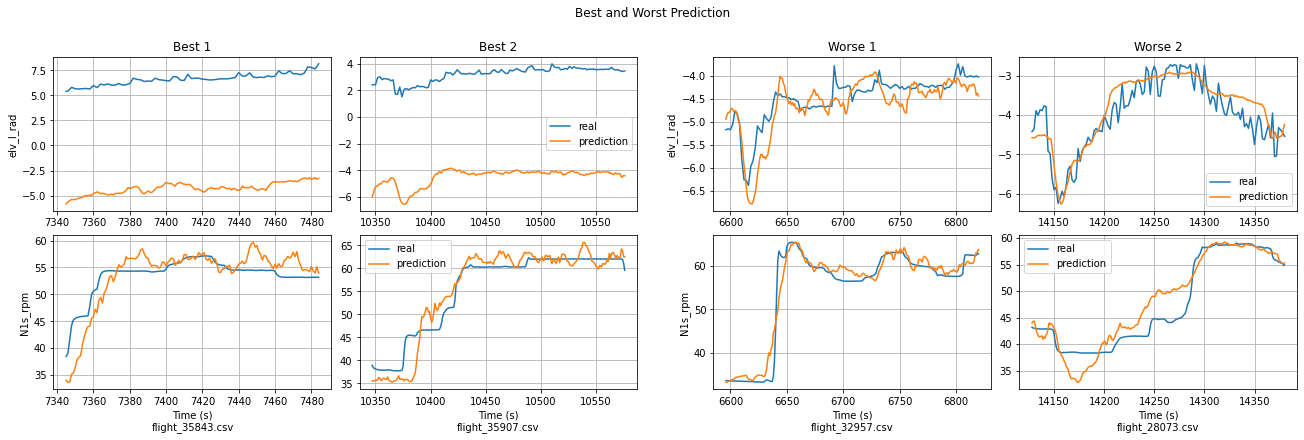

In [21]:
metric_label = ["r2_elv_l_rad"]
# metric_label = ["r2_N1s_rpm"]
metric_label = ["mae_elv_l_deg"]

plot_best_and_worst(metric_label)

/tmp/ipykernel_36084/4126840474.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


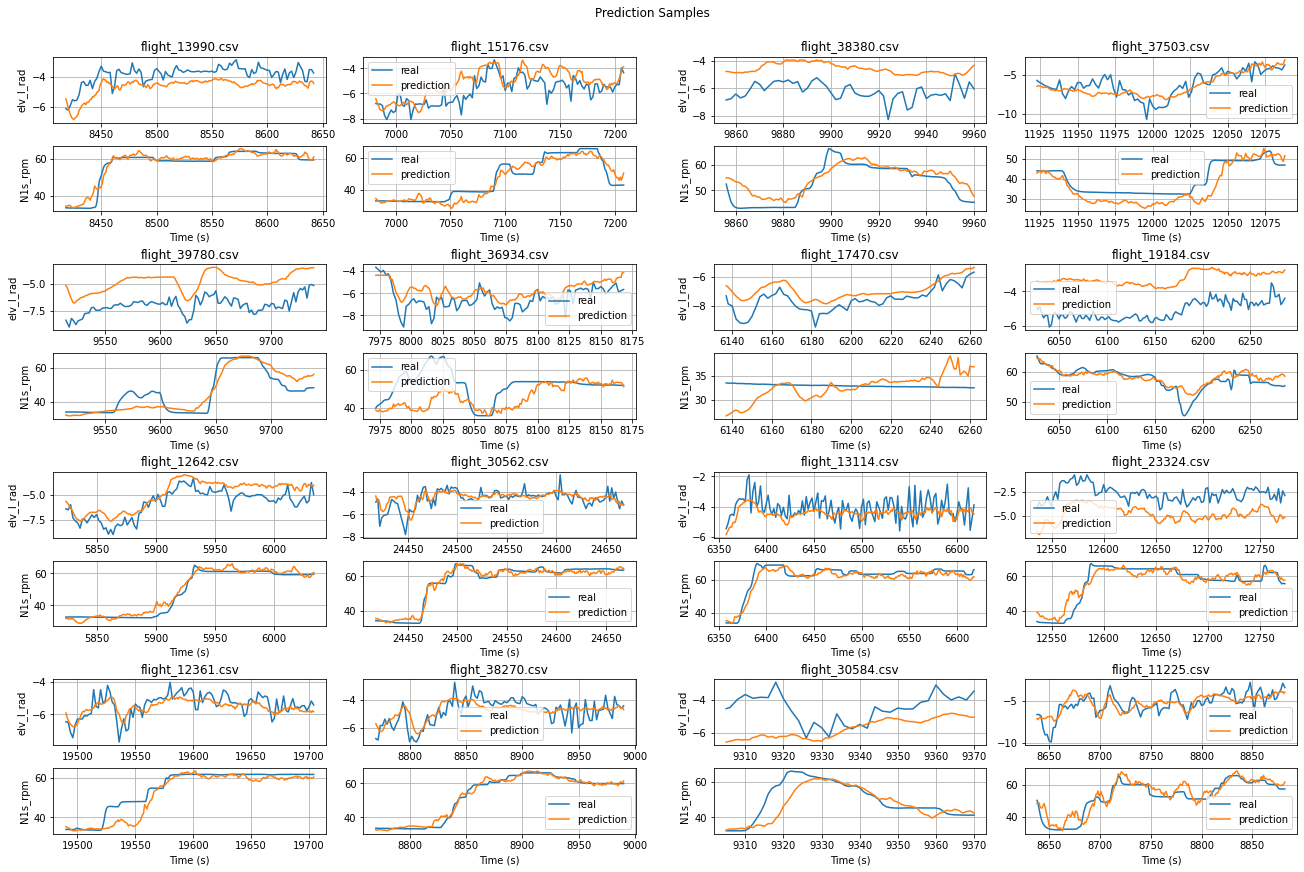

In [22]:
row = 4
col = 4

n = row*col
filelist = list(r2_df.sample(n).iloc[:, 0])

PlotManyPredictions(filelist, r=row)

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1, 4)              564       
_________________________________________________________________
flatten_1 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 14)                70        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 30        
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 2)              0         
Total params: 664
Trainable params: 664
Non-trainable params: 0
_________________________________________________________________


In [24]:
for i, layer in enumerate(model.layers):
    if isinstance(layer, tf.keras.layers.Dropout):
        print ("layer {}, rate: {}".format(i, layer.rate))

In [25]:
# Import Data
train_comb= ImportCombinedTrainingData()

# Pre-process Data
train_comb, norm_param = DF_Nomalize(train_comb)
train_list, test_list, eval_list = GetFileList()

# Create WindowGenerator
windowG = CreateWindowGenerator(train_list, 
                test_list, eval_list, norm_param)

model.evaluate(windowG.test)

464/464 [==============================] - 5s 9ms/step - loss: 0.3980 - mean_squared_error: 0.3980 - mean_absolute_error: 0.3704


[0.3980480432510376, 0.3980480432510376, 0.37039273977279663]

In [26]:
file_path = os.path.join (ph.GetProcessedPath("Selected"), "flight_10930.csv")

ds = windowG.make_dataset([file_path], batch_size=None)
features, labels = next(iter(ds))

predictions = model.predict(features)
print ('features:')

shape = features[0].shape
for i in range (shape[0]):
    for j in range (shape[1]):
        print (float(features[0][i][j]), end=', ')
    print (';')
print ('predictions: \n{}'.format(predictions[0]))

features:
0.7260112384629552, 1.1122046625694457, -0.7053813811687746, -0.5800092924308636, -0.6229121155460389, 0.16497767987658193, -0.5202047238762149, ;
0.6993123003781321, 0.7101273123667273, -0.6866446155657772, -0.6456276627298079, -0.4533306759951582, -0.010916636980490267, 0.827820189033893, ;
0.7148866809276122, 0.6431144206662743, -0.6179413344109254, -0.684226704082128, -0.2143957852202113, -0.05365724808458853, 1.1684971860001594, ;
0.7460354420265726, 0.1740241787631032, -0.5242542532969856, -0.7189658412992159, 0.05515640451883416, -0.038117350096437, 1.3188950289656216, ;
0.7549350880548469, 0.3750628538644624, -0.39309364097705424, -0.7305455537049118, 0.24057342290965264, -0.0332150329013842, 0.9056074851121447, ;
0.7616098225760527, 0.5761015289658216, -0.27442384427034755, -0.7498450743810715, 0.36423222442298164, -0.10286383908229843, 0.6022396859258795, ;
0.7638347340831213, 0.10701128706265012, -0.16824594754318334, -0.7575648826515351, 0.44139962773208996, -0.15

In [27]:
# print (windowG.norm_param)
features_columns = [
            'hralt_m', 'hdot_1_mps', 'theta_rad', 'cas_mps', 
            'gamma_error_rad', 'tailwind_mps', 'g_err_d_rad',
] # ['hralt_m', 'theta_rad', 'cas_mps', 'hdot_1_mps', 'gamma_error_rad', 'elv_l_rad', 'N1s_rpm']

norm_param_df = pd.DataFrame(windowG.norm_param)
norm_param_df.to_csv('norm_param.csv')

# means
for feature in features_columns:
    print (norm_param[feature][0], end=' ')
print ()

# std
for feature in features_columns:
    print (norm_param[feature][1], end=' ')
print ()

275.13986205308777 -3.6248340917298663 -0.04852269318282636 68.33258955598978 0.0004397638769803771 2.2713513051963763 1.4538571210263267e-05 
136.99421259301505 1.2129009499145444 0.030699522246907234 8.329870088358422 0.013746434685620602 4.126592181112448 0.002798435749885401 


In [28]:
labels_columns = [
            'elv_l_rad', 'N1s_rpm'
] # ['hralt_m', 'theta_rad', 'cas_mps', 'hdot_1_mps', 'gamma_error_rad', 'elv_l_rad', 'N1s_rpm']

# means
for label in labels_columns:
    print (norm_param[label][0], end=' ')
print ()

# std
for label in labels_columns:
    print (norm_param[label][1], end=' ')
print ()

-0.08195467013597951 51.745608970328384 
0.04219675589445049 11.37354295004407 


In [5]:
file_path = os.path.join (ph.GetProcessedPath("Selected"), "flight_10930.csv")
df = pd.read_csv(file_path)

features_columns = [
            'hralt_m', 'hdot_1_mps', 'theta_rad', 'cas_mps', 
            'gamma_error_rad', 'tailwind_mps', 'g_err_d_rad', 'elv_l_rad', 'N1s_rpm'
] # ['hralt_m', 'theta_rad', 'cas_mps', 'hdot_1_mps', 'gamma_error_rad', 'elv_l_rad', 'N1s_rpm']

newdf = df.iloc[0:9, :].loc[:, features_columns ]
# newdf.to_csv("cut_flight_10930.csv", index=False)


for feature in features_columns:
    tosave_df = df.loc[:, feature ].to_frame()
    tosave_df.rename(columns={feature:'f (t)'}, inplace=True)
    tosave_df.index.name = 't (s)'
    tosave_df.to_csv('{}.csv'.format(feature), header=False)

newdf

,hralt_m,hdot_1_mps,theta_rad,cas_mps,gamma_error_rad,tailwind_mps,g_err_d_rad,elv_l_rad,N1s_rpm
0,374.5992,-2.27584,-0.070178,63.501188,-0.008123,2.952147,-0.001441,-0.050916,52.953125
1,370.9416,-2.76352,-0.069602,62.954595,-0.005792,2.226303,0.002331,-0.053951,52.984375
2,373.0752,-2.84480,-0.067493,62.633070,-0.002507,2.049930,0.003285,-0.052523,52.945312
3,377.3424,-3.41376,-0.064617,62.343697,0.001198,2.114057,0.003705,-0.051095,52.968750
4,378.5616,-3.16992,-0.060590,62.247240,0.003747,2.134286,0.002549,-0.050381,52.945312
5,379.4760,-2.92608,-0.056947,62.086478,0.005447,1.846874,0.001700,-0.049667,52.968750
6,379.7808,-3.49504,-0.053688,62.022173,0.006507,1.631097,0.001061,-0.047703,52.929688
7,379.7808,-3.57632,-0.051195,61.668495,0.006987,1.700699,0.000479,-0.045739,52.945312
8,375.2088,-3.65760,-0.048702,61.539885,0.007029,1.481923,0.000042,-0.045917,52.953125


In [39]:
np.set_printoptions(precision=4, suppress=True)
labels_list = []
for i in range(newdf.shape[0] - 6 + 1):
    print ("i = {}".format(i))

    print ("feature_{}".format(i))
    print (newdf.iloc[i:(i+5), :5].to_numpy())

    labels_list.append(
        newdf.iloc[i+5, -2:].to_numpy().tolist()
    )

print ("Labels: \n{}".format(np.array(labels_list)))

i = 0
feature_0
[[374.5992  -0.0702  63.5012  -2.2758  -0.0081]
 [370.9416  -0.0696  62.9546  -2.7635  -0.0058]
 [373.0752  -0.0675  62.6331  -2.8448  -0.0025]
 [377.3424  -0.0646  62.3437  -3.4138   0.0012]
 [378.5616  -0.0606  62.2472  -3.1699   0.0037]]
i = 1
feature_1
[[370.9416  -0.0696  62.9546  -2.7635  -0.0058]
 [373.0752  -0.0675  62.6331  -2.8448  -0.0025]
 [377.3424  -0.0646  62.3437  -3.4138   0.0012]
 [378.5616  -0.0606  62.2472  -3.1699   0.0037]
 [379.476   -0.0569  62.0865  -2.9261   0.0054]]
i = 2
feature_2
[[373.0752  -0.0675  62.6331  -2.8448  -0.0025]
 [377.3424  -0.0646  62.3437  -3.4138   0.0012]
 [378.5616  -0.0606  62.2472  -3.1699   0.0037]
 [379.476   -0.0569  62.0865  -2.9261   0.0054]
 [379.7808  -0.0537  62.0222  -3.495    0.0065]]
i = 3
feature_3
[[377.3424  -0.0646  62.3437  -3.4138   0.0012]
 [378.5616  -0.0606  62.2472  -3.1699   0.0037]
 [379.476   -0.0569  62.0865  -2.9261   0.0054]
 [379.7808  -0.0537  62.0222  -3.495    0.0065]
 [379.7808  -0.0512  

In [ ]:
file_path = os.path.join (ph.GetProcessedPath("Raw"), "flight_10930.csv")
df = pd.read_csv(file_path)

#newdf = df.iloc[0:9, :].loc[:, ['hralt_m', 'theta_rad', 'cas_mps', 'hdot_1_mps', 'gamma_error_rad', 'elv_l_rad', 'N1s_rpm'] ]
#newdf.to_csv("cut_flight_10930.csv", index=False)
#newdf

plt.scatter (df['time_s'], df['hralt_m'], marker='X')

freq = int (1/0.125)

divider = int (freq / .5)
i_list = [a*divider for a in range(int(df.shape[0]/divider))]
df = df.iloc[i_list, :]
df.reset_index(drop=True, inplace=True)

In [ ]:
#
# plt.style.use('science')

split_range = slice(530/2, 560/2)

with plt.style.context(['science', 'ieee']):
    plt.scatter (df.loc[split_range, 'time_s'], df.loc[split_range, 'elv_l_rad'] * 180/math.pi, marker='x')
    plt.xlabel('time (s)')
    plt.ylabel('Elevator Deflection (deg)')
    plt.ylim((-45, 20))

In [ ]:
new_df = df.copy()
new_df.loc[new_df['elv_l_rad'] < -20*math.pi/180] = np.nan
new_df = new_df.interpolate()

with plt.style.context(['science', 'ieee']):
    plt.scatter (new_df.loc[split_range, 'time_s'], new_df.loc[split_range, 'elv_l_rad'] * 180/math.pi, marker='x')
    plt.xlabel('time (s)')
    plt.ylabel('Elevator Deflection (deg)')
    plt.ylim((-45, 20))

In [ ]:
df.loc[df['elv_l_rad'] < -20*math.pi/180].loc[:, ['time_s', 'elv_l_rad']]

In [ ]:
-0.731293*180/math.pi

In [ ]:
with plt.style.context(['science', 'ieee']):
    plt.plot (df.loc[:, 'time_s'], df.loc[:, 'hralt_m'])
    plt.xlabel('time (s)')
    plt.ylabel('Altitude (m)')
    # plt.ylim((-45, 20))

In [ ]:
file_path = os.path.join (ph.GetProcessedPath("Selected"), "flight_10930.csv")
sam_df = pd.read_csv(file_path)

with plt.style.context(['science', 'ieee']):
    plt.plot (sam_df.loc[:, 'time_s'], sam_df.loc[:, 'hralt_m'])
    plt.xlabel('time (s)')
    plt.ylabel('Altitude (m)')